# AFESim Module Tutorial

In this tutorial, we will cover the usage and functionalities of the `AFESim` module which simulates the audio signal preprocessing on the Xylo A3 chip.

## Getting Started

Let's first investigate the block diagram of the input pre-processing pipeline, namely **A**udio **F**ront-**E**nd on the Xylo A3 chip.


In [1]:
from IPython.display import Image
Image("figures/av3_block.png")

In [2]:
# from rockpool.devices.xylo.syns65302 import AFESim, AUDIO_SAMPLING_RATE, ChipButterworth, DivisiveNormalization, Raster
# import librosa
# import matplotlib.pyplot as plt
# import numpy as np


import librosa
import numpy as np
import matplotlib.pyplot as plt
from rockpool.devices.xylo.syns65302 import AFESim
from rockpool.timeseries import TSContinuous, TSEvent

from samna.xyloA3.configuration import InputInterfaceConfig


## Load the audio file

Note: If you want to generate a new one, please navigate to `generate_chirp.py` and run it.

In [3]:
filename = 'freq_sweep.wav'
y, sr = librosa.load(filename, sr=None)  # sr=None preserves the original sampling rate

## Quantize the signal to 14 bits

In [4]:
scale = 1
num_bits = 14
q_signal = np.vectorize(lambda __data : int(scale * __data * (2 ** (num_bits - 1))), )(y)

## Use AFESim

Construct using `.from_specifications()` method.

In [5]:
# Default parameters
afesim = AFESim.from_specification(
    select_filters = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
    spike_gen_mode = "divisive_norm",
    rate_scale_factor = 63,
    low_pass_averaging_window = 84e-3,
    dn_EPS = 1,
    fixed_threshold_vec = 2**27,
    dt = 1024e-6,
)

# OR using the default object constructor

# afesim = AFESim(
#     select_filters = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15),
#     spike_gen_mode = "divisive_norm",
#     dn_rate_scale_bitshift = (6, 0),
#     dn_low_pass_bitshift = 12,
#     dn_EPS = 1,
#     fixed_threshold_vec = 2**27,
#     down_sampling_factor = 50,
# )

In [23]:
print("dt : ", afesim.dt)
print("low_pass_averaging_window : ", afesim.low_pass_averaging_window)
print("rate_scale_factor : ", afesim.rate_scale_factor)

dt :  0.001024
low_pass_averaging_window :  0.08388608
rate_scale_factor :  63


In [6]:
out, state, rec = afesim(q_signal)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:338: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)
 [py.warnings]
  sig_in = jnp.asarray(sig_in, dtype=jnp.int64)

WARNING    /Users/ugurcancakal/SynSense Dropbox/Ugurcan Cakal/repos/rockpool/rockpool/devices/xylo/syns65302/afe/divisive_normalization.py:340: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in asarray is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.c

## Filter output

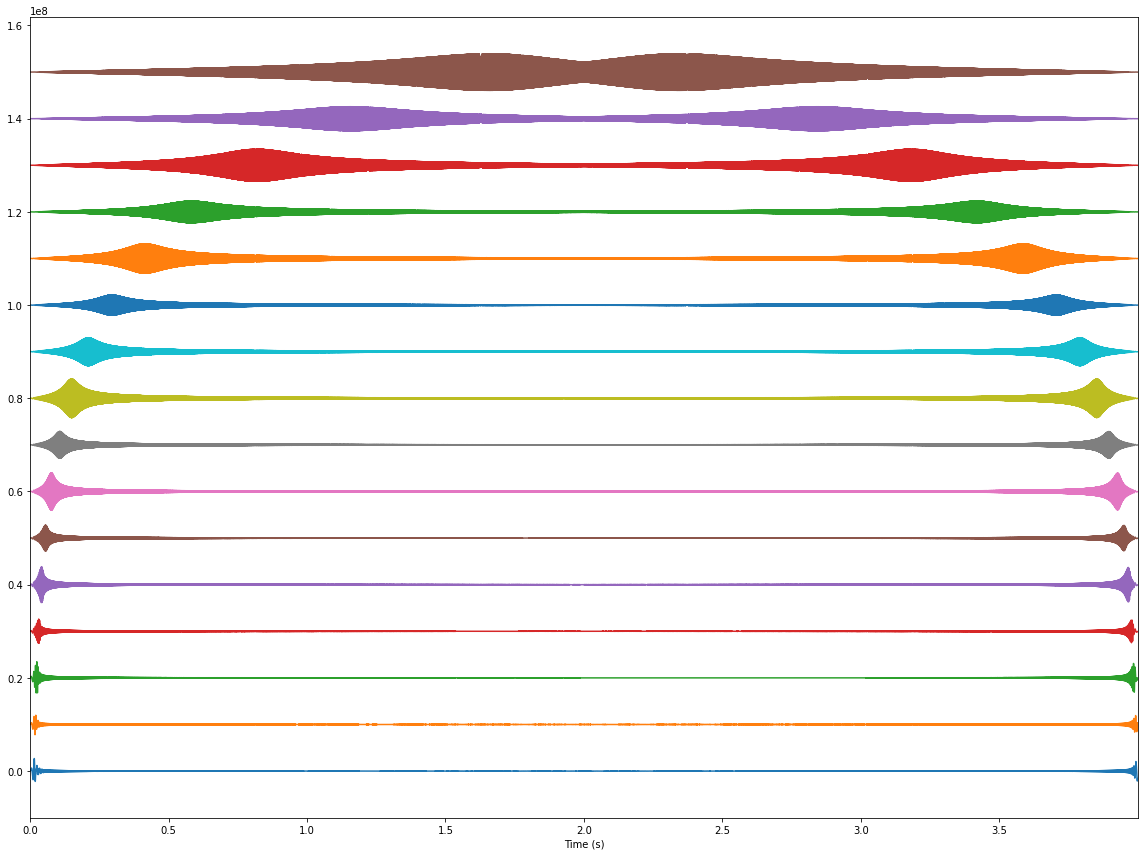

In [7]:
filtered_signal = rec["0_ChipButterworth_output"]
plt.figure(figsize=(16, 12))
TSContinuous.from_clocked(filtered_signal, dt=1/sr).plot(stagger=1e7)
plt.tight_layout()
plt.show()

## Divisive Normalization Output

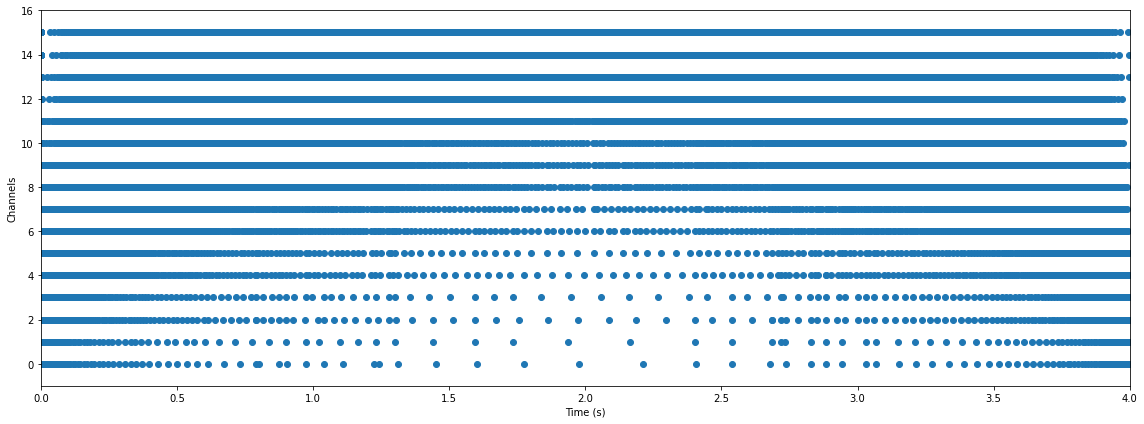

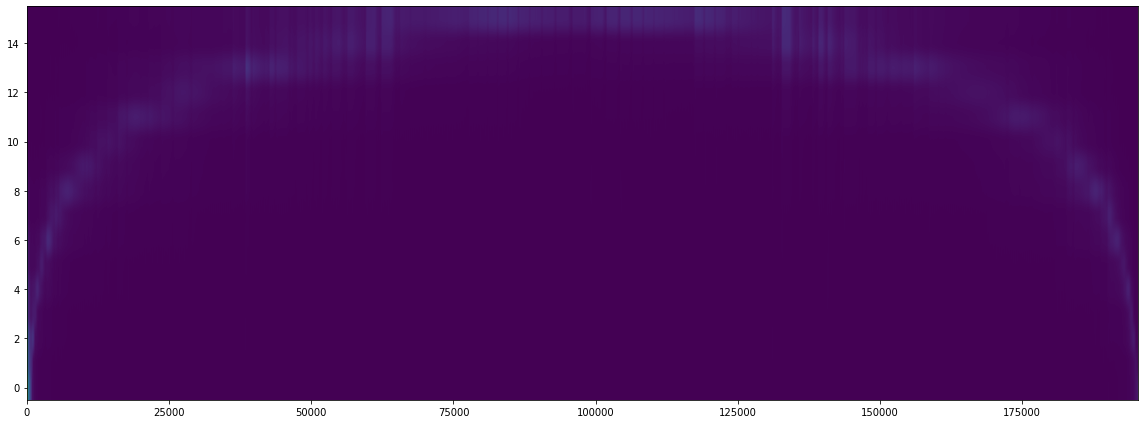

In [13]:
spike_out_div = rec["1_DivisiveNormalization_output"]
plt.figure(figsize=(16, 6))
TSEvent.from_raster(spike_out_div, dt=1/sr).plot()
plt.tight_layout()
plt.figure(figsize=(16, 6))
plt.imshow(spike_out_div.T, aspect = 'auto', origin = 'lower')
plt.tight_layout()

## Accumulated spikes

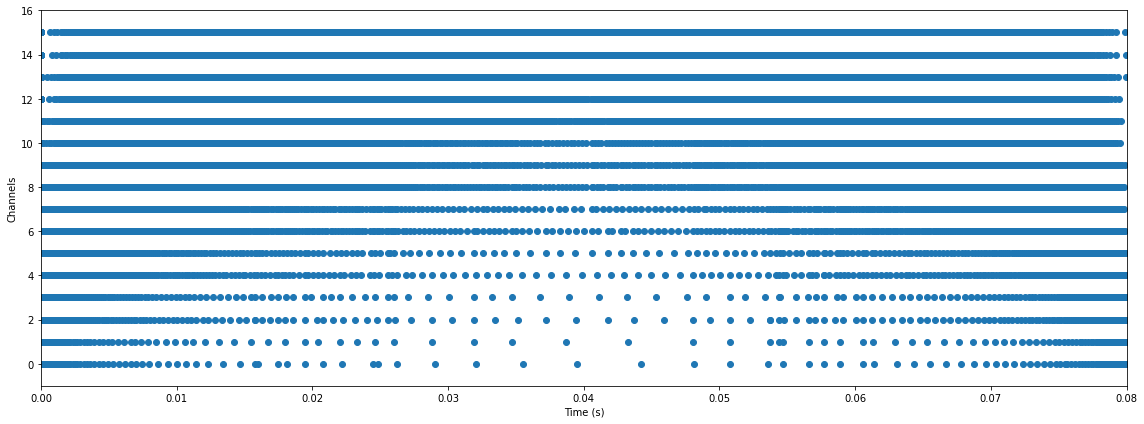

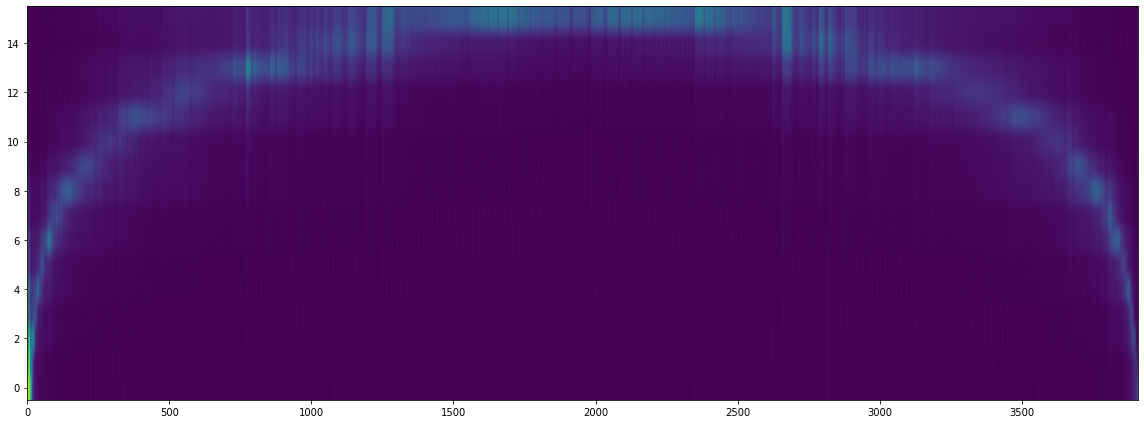

In [15]:
plt.figure(figsize=(16, 6))
TSEvent.from_raster(out, dt=1/sr).plot()
plt.tight_layout()
plt.figure(figsize=(16, 6))
plt.imshow(out.T, aspect = 'auto', origin = 'lower')
plt.tight_layout()

Channel 0  3487.714285714286
Channel 1  1808.4444444444443
Channel 2  775.047619047619
Channel 3  315.01935483870966
Channel 4  241.72277227722773
Channel 5  168.95501730103805
Channel 6  223.9816513761468
Channel 7  139.90830945558739
Channel 8  138.7159090909091
Channel 9  70.97093023255815
Channel 10  91.60975609756098
Channel 11  93.00571428571429
Channel 12  63.3307392996109
Channel 13  33.14867617107943
Channel 14  26.50814332247557
Channel 15  31.080840229153406


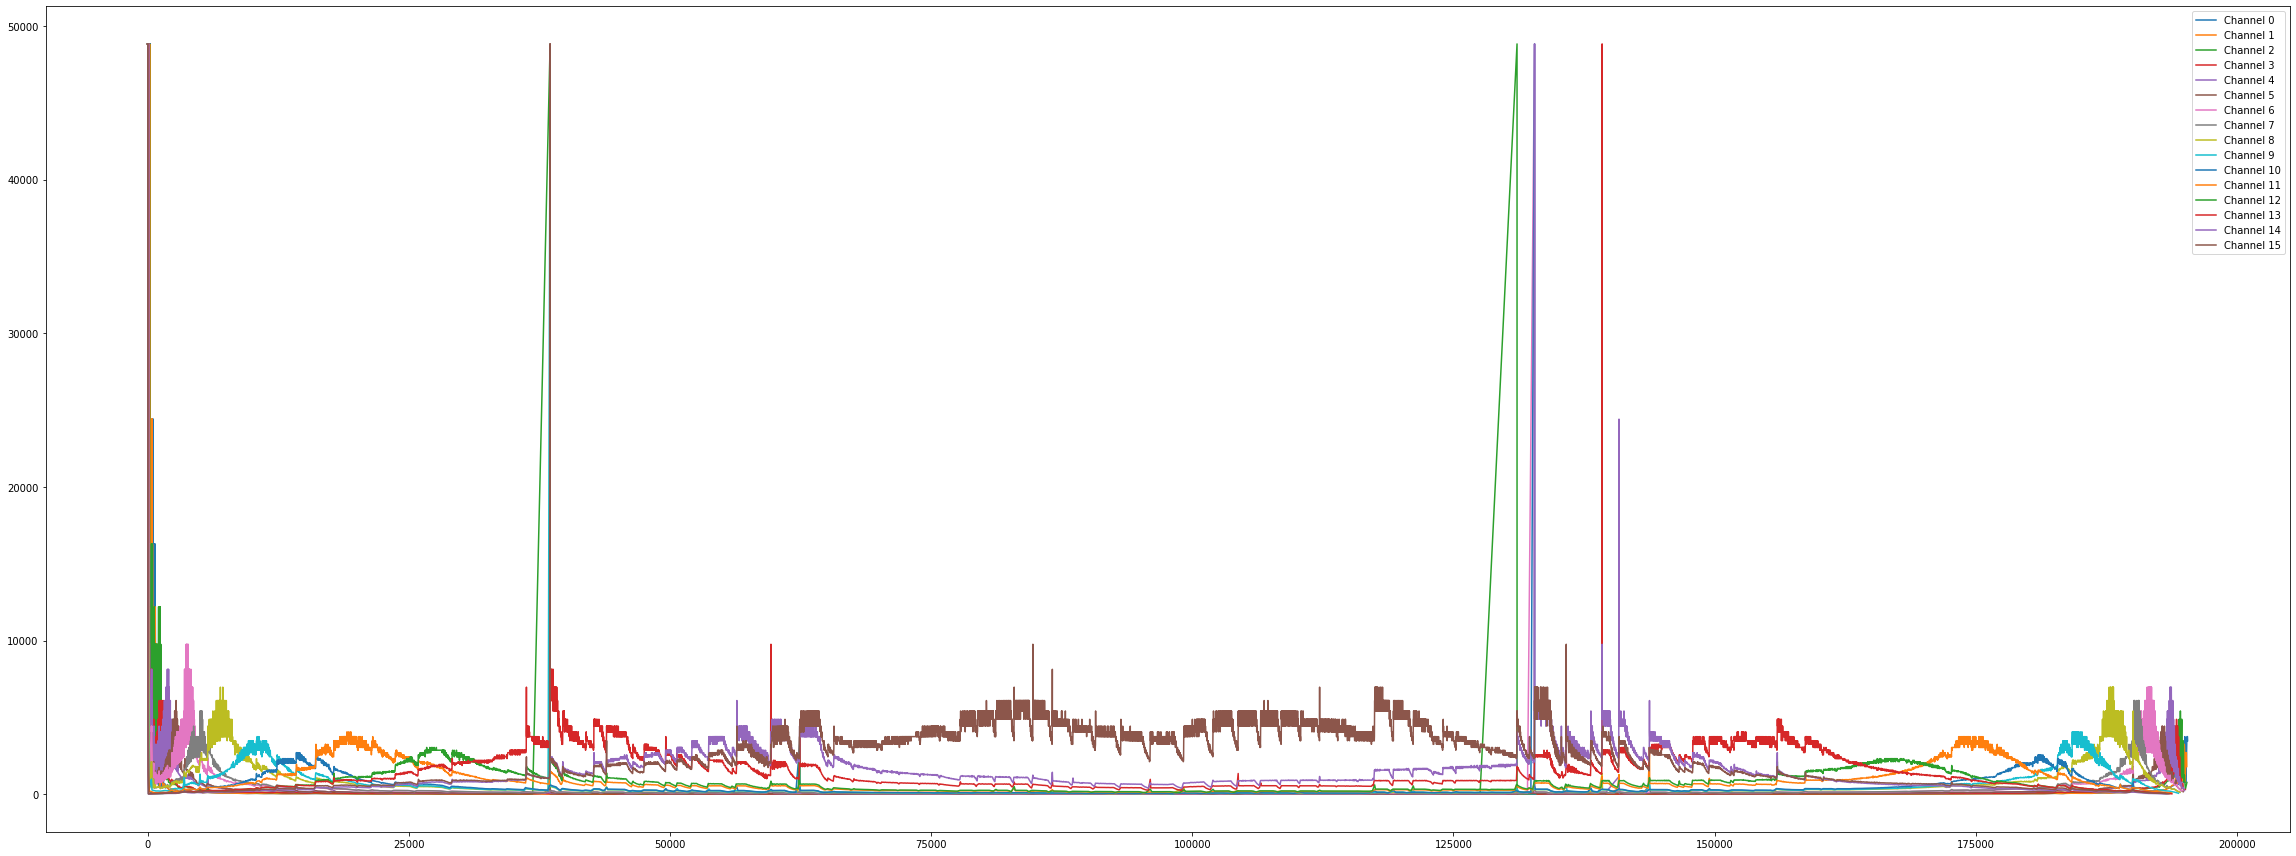

In [17]:
plt.figure(figsize=(32, 12))

for i in range(afesim.size_out):
    spike_ch = spike_out_div[:,i]
    spike_times = np.where(spike_ch == 1)[0]
    spike_rate = sr/np.diff(spike_times)
    # print(spike_times[:-1].shape)
    # print(spike_rate.shape)
    # break
    plt.plot(spike_times[:-1], spike_rate, label=f'Channel {i}')
    print(f"Channel {i} ", spike_rate[-1])

plt.legend()
plt.tight_layout()
# spike_rate.T[-1]
# spike_times
# 1/np.diff(spike_times)

Channel 0  8138.0
Channel 1  12207.0
Channel 2  48828.0
Channel 3  16276.0
Channel 4  12207.0
Channel 5  8138.0
Channel 6  12207.0
Channel 7  6975.428571428572
Channel 8  6975.428571428572
Channel 9  3756.0
Channel 10  4438.909090909091
Channel 11  4882.8
Channel 12  3255.2
Channel 13  1627.6
Channel 14  1356.3333333333333
Channel 15  1525.875


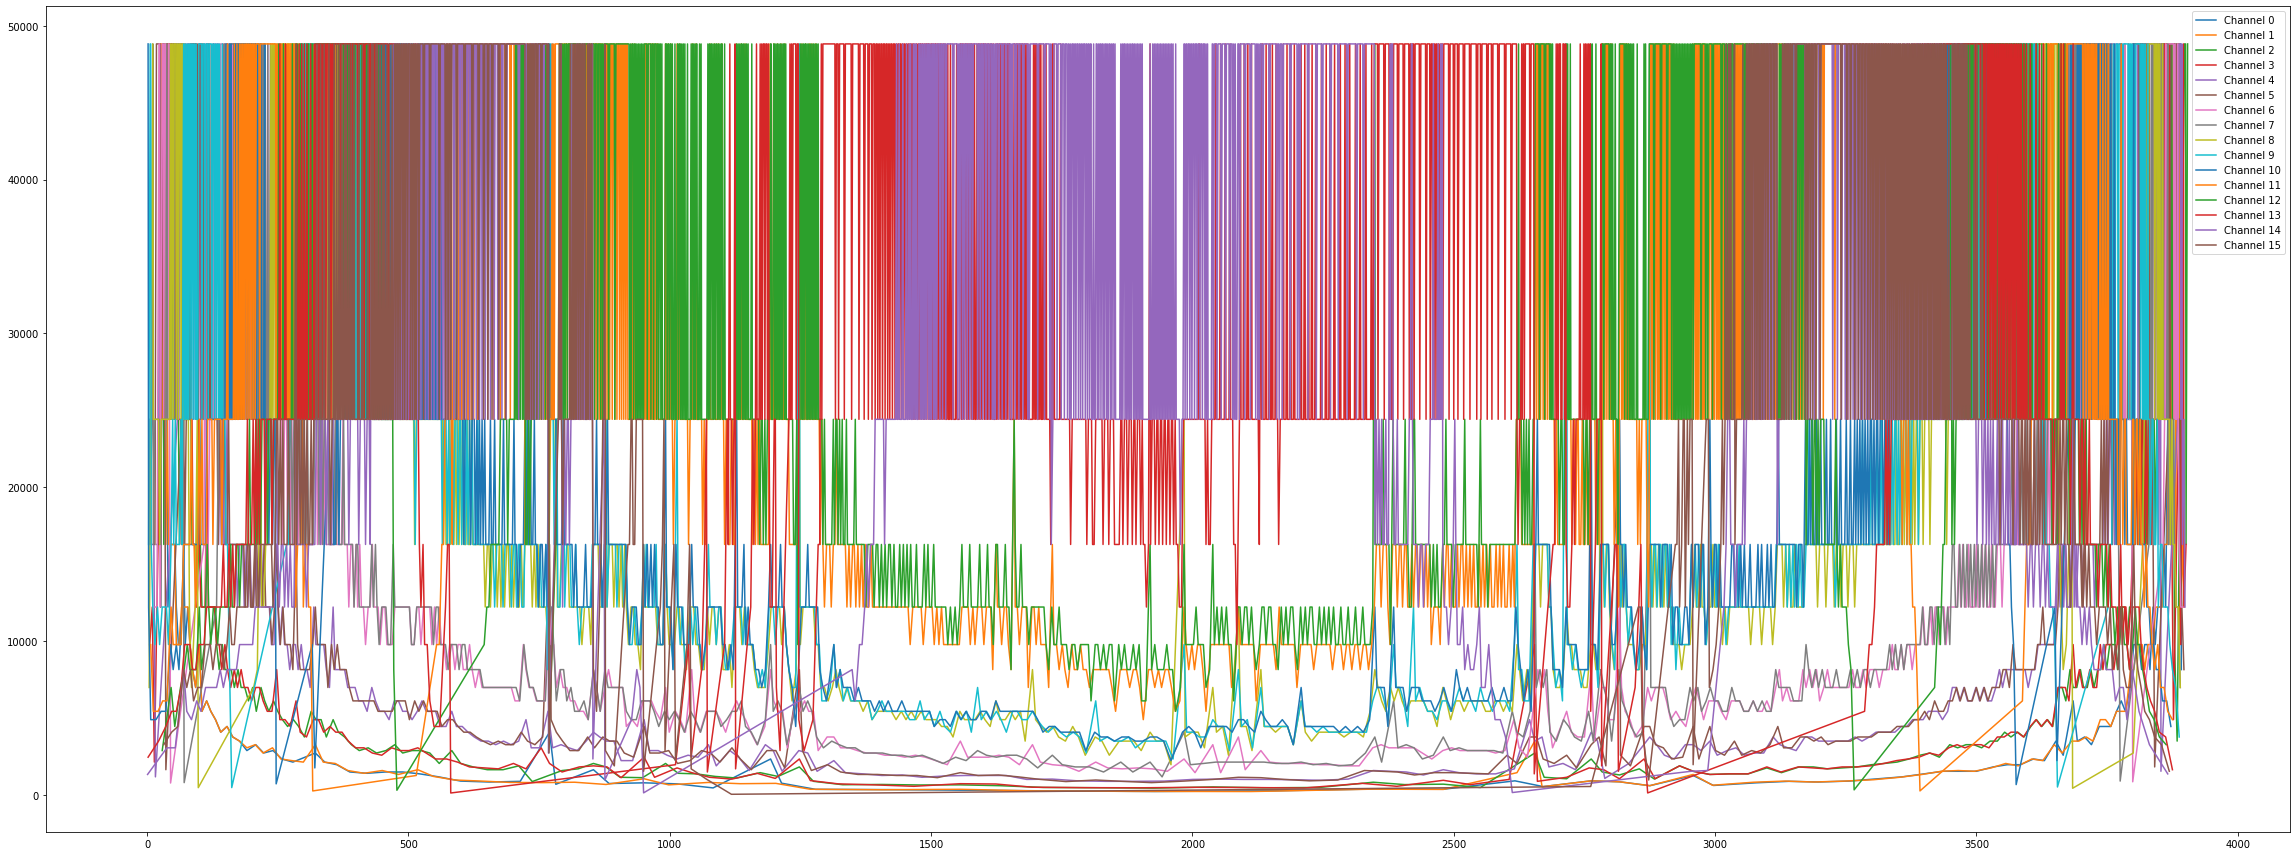

In [18]:
plt.figure(figsize=(32, 12))

for i in range(afesim.size_out):
    spike_ch = out[:,i]
    spike_times = np.where(spike_ch == 1)[0]
    spike_rate = sr/np.diff(spike_times)
    # print(spike_times[:-1].shape)
    # print(spike_rate.shape)
    # break
    plt.plot(spike_times[:-1], spike_rate, label=f'Channel {i}')
    print(f"Channel {i} ", spike_rate[-1])

plt.legend()
plt.tight_layout()
# spike_rate.T[-1]
# spike_times
# 1/np.diff(spike_times)